# Interpreting the json data for the paradigm #

Set the export filename and the row you want to extract here.

In [1]:
EXPORT_FILENAME = "../data/Complete-R_1pEtRZqANLuT9P4-2021-04-10T07_17_16_380Z.json"
AUXILIARY_REPORT = "Apprendimento motorio e anticipazione di ricompense in pazienti con Parkinson_June 2, 2021_08.35.xml"
AUXILIARY_REPORT2 = "Investigating the relationship between reward prediction and learning_June 2, 2021_08.34.xml"


## Code Setup ##

This script mostly relies on `json` and `pandas` for data display. `numpy` is used for the mean function. `csv` and `xml` are used for the file parsing.

In [2]:
import numpy as np
import pandas as pd
import math
import json
import csv
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

GAME_SCREEN = 19
POINTS_PER_ROUND = 10
ROUND_NUM_CORRECTION = 2
NUM_ROUNDS = 180

In [3]:
def try_float(num):
    try:
        float(num)
    except TypeError:
        print(f"{num}")
        return math.nan


### Reading the Export Data ###
For English, read off finished, _recordId and QID44_TEXT. pdYear will be recorded as None for all participants

In [4]:
participant_data = []

tree = ET.parse(AUXILIARY_REPORT2)

root = tree.getroot()
for row in tree.findall("Response"):
    record = {}
    record["finished"] = row.find("finished").text == "True"

    record["isPD"] = False
    record["pdYear"] = None

    qid44Node = row.find("QID44_TEXT")
    record["age"] = None if qid44Node is None else qid44Node.text

    record["id"] = row.find("_recordId").text
    record["lang"] = "EN"

    participant_data.append(record)


### Reading XML exports ###
For Italian, read off finished, QID7, QID8_TEXT, QID16_TEXT, and _recordId

In [5]:
tree = ET.parse(AUXILIARY_REPORT)

root = tree.getroot()
for row in tree.findall("Response"):
    record = {}
    record["finished"] = row.find("finished").text == "True"

    PdPositive = row.find("QID7")
    record["isPD"] = None if PdPositive is None else PdPositive.text == "Si"

    qid8Node = row.find("QID8_TEXT")
    record["pdYear"] = None if qid8Node is None else qid8Node.text

    qid16Node = row.find("QID16_TEXT")
    record["age"] = None if qid16Node is None else qid16Node.text

    record["id"] = row.find("_recordId").text
    record["lang"] = "IT"

    participant_data.append(record)


We split each participant into the three groups specified in the study design: Young, Old and PD.

In [53]:
young      = pd.DataFrame([x["id"] for x in participant_data if x["finished"] and x["age"] is not None and int(x["age"]) < 40])
old        = pd.DataFrame([x["id"] for x in participant_data if x["finished"] and x["age"] is not None and int(x["age"]) > 59])
parkinsons = pd.DataFrame([x["id"] for x in participant_data if x["finished"] and x["isPD"]])

In [58]:
# pd.DataFrame(participant_data)

### Direct JSON export ###
If you're reading directly from a json file, use this code.

In [7]:
if EXPORT_FILENAME.endswith('.json'):
    with open(EXPORT_FILENAME) as jso:
        s = json.load(jso)


### Linking the active Participant data ###


In [8]:
activeId = s['id']
active_participant = [x for x in participant_data if x["id"] == activeId]

active_participant

[{'finished': True,
  'isPD': False,
  'pdYear': None,
  'age': '29',
  'id': 'R_1pEtRZqANLuT9P4',
  'lang': 'EN'}]

## Probability contingencies ##

This code returns the results of each round, and includes the underlying probabilities which led to that decision.

In [9]:
# Gets the score result of each round
roundResult = []

score = 0
for i in range(0, len(s['eventLog'])):
    # We'll need the current row and the row preceding it to get all the data we need
    entry = s['eventLog'][i]
    previousEntry = s['eventLog'][i-1]

    # Focus on winRound, lostRound, incorrectPlay and timedOut rows only
    if entry['type'] == 'winRound' or entry['type'] == 'lostRound':
        if entry['type'] == 'winRound':
            score += POINTS_PER_ROUND
        # The sequence chosen must be obtained from the previous row
        # Where the sequenced is assessed, we can find the probability contingencies in the activeProbability,
        # unchosenProbability and mcsScore fields
        row = dict({
            'round': entry['trial'] - ROUND_NUM_CORRECTION,
            'type': entry['type'],
            'sequence': previousEntry['sequence'] if 'sequence' in previousEntry else None,
            'probability1': entry['activeProbability'] if 'activeProbability' in entry else None,
            'probability2': entry['unchosenProbability'] if 'unchosenProbability' in entry else None,
            'urn': entry['mcsScore'],
            'score': score
        })
        roundResult.append(row)
    elif entry['type'] == 'incorrectPlay' or entry['type'] == 'timedOut':
        row = dict({
            'round': entry['trial'] - ROUND_NUM_CORRECTION,
            'type': entry['type'],
            'sequence': previousEntry['sequence'] if 'sequence' in previousEntry else None,
            'probability1': None,
            'probability2': None,
            'urn': None,
            'score': score
        })
        
        roundResult.append(row)

roundResultDataFrame = pd.DataFrame(roundResult)

#### Output ####
* If the round ended in `incorrectPlay` or `timedOut`, the player always loses.
* `probability1` holds the probability sequence 1 was the winner and `probability2` holds the probability sequence 2 was the winner.
* `urn` holds the random score which determines whether the player won the round or lost it.

In [10]:
roundResultDataFrame

,round,type,sequence,probability1,probability2,urn,score
0,0,winRound,gjhk,0.9,0.1,0.183458,10
1,1,timedOut,None,NaN,NaN,NaN,10
2,2,winRound,gjhk,0.9,0.1,0.391314,20
3,3,timedOut,None,NaN,NaN,NaN,20
4,4,lostRound,kgjh,0.9,0.1,0.635858,20
...,...,...,...,...,...,...,...
175,175,lostRound,kgjh,0.5,0.5,0.050793,1090
176,176,lostRound,gjhk,0.5,0.5,0.936219,1090
177,177,winRound,kgjh,0.5,0.5,0.643075,1100
178,178,lostRound,kgjh,0.5,0.5,0.274230,1100


## Interstroke key timings for all rounds ##

This code returns the interstroke key time for all rounds.

In [11]:
timingarray = []
lastTimestamp = None
currentTimestampBucket = []
timelist = []

for entry in (x for x in s['eventLog'] if x['round'] == GAME_SCREEN):
    if entry['type'] == 'startNextRound':

        if (len(currentTimestampBucket) == 0):
            if len(timingarray) == 0:
                continue
            row = dict({'screen': entry['round'], 'round': entry['trial'] - ROUND_NUM_CORRECTION, 'timings': None, 'timestamps': None, 'meankeystrokeinterval': None })
        else:
            meanval = np.nanmean(currentTimestampBucket)
            probabilityRow = roundResultDataFrame[roundResultDataFrame["round"] == entry["trial"] - ROUND_NUM_CORRECTION]
            probability = float(probabilityRow["probability1"])

            row = dict({
                'screen': entry['round'],
                'round': entry['trial'] - ROUND_NUM_CORRECTION,
                "probability": probability,
                'timings': currentTimestampBucket.copy(),
                'timestamps': timelist.copy(),
                'meankeystrokeinterval': meanval,
            })
        timingarray.append(row)
        lastTimestamp = None
        currentTimestampBucket.clear()
        timelist.clear()
    elif entry['type'] == 'keydown':
        if lastTimestamp is not None:
            currentTimestampBucket.append(entry['time'] - lastTimestamp)
        timelist.append(entry['time'])
        lastTimestamp = entry['time']

        
# Now record information for the final round
if (len(currentTimestampBucket) == 0):
    if len(timingarray) != 0:
        row = dict({'screen': entry['round'], 'round': NUM_ROUNDS, 'timings': None, 'timestamps': None, 'meankeystrokeinterval': None })
    timingarray.append(row)
else:
    meanval = np.nanmean(currentTimestampBucket)
    probabilityRow = roundResultDataFrame[roundResultDataFrame["round"] == NUM_ROUNDS - 1]
    probability = float(probabilityRow["probability1"])

    row = dict({
        'screen': entry['round'],
        'round': NUM_ROUNDS,
        "probability": probability,
        'timings': currentTimestampBucket.copy(),
        'timestamps': timelist.copy(),
        'meankeystrokeinterval': meanval,
    })
    timingarray.append(row)

# Finally convert everything into a dataframe
timingdata = pd.DataFrame(timingarray)

#### Output ####
* `screen` is fixed and equal to the GAME_SCREEN
* `round` indicates the round of the experiment (out of 180)
* `timings` is an array holding the set of raw timings (in ms) between each keystroke, from which
* `timestamps` are the raw timestamps from the browser from which `timings` is calculated (it is the time in ms since page load)
* meankeystrokeinterval is the mean timings between each keydown stroke in the round, also known as the interstroke interval


In [12]:
# with pd.option_context("display.max_row", None, "display.max_columns", None):
display(timingdata)


,screen,round,probability,timings,timestamps,meankeystrokeinterval
0,19,1,NaN,"[577.919999952428, 469.48000008706003, 476.589...","[983444.3500000052, 984022.2699999576, 984491....",507.996667
1,19,2,0.9,[505.34500007051975],"[996621.204999974, 997126.5500000445]",505.345000
2,19,3,NaN,"[483.33000007551163, 407.84499992150813, 397.3...","[1007773.3399999561, 1008256.6700000316, 10086...",429.498333
3,19,4,0.9,[996.5699999593198],"[1023797.7950000204, 1024794.3649999797]",996.570000
4,19,5,0.9,"[603.4399999771267, 401.77500003483146, 455.04...","[1031368.6699999962, 1031972.1099999733, 10323...",486.751667
...,...,...,...,...,...,...
175,19,176,0.5,"[386.39999995939434, 367.35000007320195, 354.8...","[1923151.034999988, 1923537.4349999474, 192390...",369.545000
176,19,177,0.5,"[365.955000044778, 350.31999996863306, 293.905...","[1927767.0849999413, 1928133.039999986, 192848...",336.726667
177,19,178,0.5,"[354.97500002384186, 305.835000006482, 340.089...","[1932434.3599999556, 1932789.3349999795, 19330...",333.633333
178,19,179,0.5,"[399.62000004015863, 323.3849999960512, 352.32...","[1937051.8499999307, 1937451.4699999709, 19377...",358.441667


### Plot ###

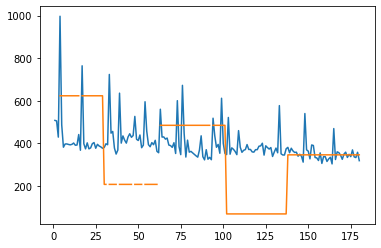

In [13]:
timing_range = np.max(timingdata["meankeystrokeinterval"]) - np.min(timingdata["meankeystrokeinterval"])
plt.plot(timingdata["round"], timingdata["meankeystrokeinterval"])

plt.plot(timingdata["round"], timingdata["probability"]*timing_range)


# Analysis Phase #


## Saving as CSV ##
Since these are pandas dataframes, converting to csv format (or any other format supported by pandas) is trivial.

#### Interstroke key data ####

In [14]:
# timingdata.to_csv('timingdata.csv')

#### Probability Contingencies ####

In [15]:
# roundResultDataFrame.to_csv('roundresults.csv')

### Participant info ####

In [59]:
young.to_excel("Young.xlsx", header = False, index = False)
old.to_excel("Old.xlsx", header = False, index = False)
parkinsons.to_excel("PD.xlsx", header = False, index = False)


For further support, contact Osama Shah oshah001@gold.ac.uk